In [1]:
import os
import sys
sys.path.insert(1, os.path.join(sys.path[0], '..'))

import matplotlib.pyplot as plt
from imp import reload
from typing import List
import os
import pickle
import pandas as pd
import numpy as np
import sys
from skimage.transform import resize

from data_utils import DataHandler
import evaluate
import text_retrieval
import image_features
import image_utils
import bg_masks
import similarities
import detect_textbox
import histogram_processing
import visualizer

N_PROCESS = 10

/var/folders/zj/hvgbgg5j4qdc72qhxpzc2x2h0000gn/T/ipykernel_21257/2169487289.py:6: DeprecationWarning: the imp module is deprecated in favour of importlib and slated for removal in Python 3.12; see the module's documentation for alternative uses
  from imp import reload


# LOAD DATA

In [2]:
data_handler = DataHandler()

# Load images:
db, db_files = data_handler.load_images(
    folder="../data/BBDD/", extension=".jpg", desc="Loading BBDD Data...")
qsd1_w4, qsd1_w4_files = data_handler.load_images(
    folder="../data/qsd1_w4_denoised/", extension=".jpg", desc="Loading qsd1_w4 Data...")

# Load text:
db_text = data_handler.load_text(
    folder="../data/BBDD/", extension=".txt", desc="Loading BBDD Text data...")
qsd1_w4_text = data_handler.load_text_multiple(
    folder="../data/qsd1_w4/", extension=".txt", desc="Loading qsd1_w4 Text data...")


Initialized DataHandler with 2 processes


Loading BBDD Data...:  27%|██▋       | 78/287 [00:01<00:03, 64.86it/s]/Users/johnny/miniconda3/envs/Team1/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
Loading BBDD Data...: 100%|██████████| 287/287 [00:05<00:00, 56.52it/s]


../data/BBDD/ read: 287 images


Loading qsd1_w4 Data...: 100%|██████████| 30/30 [00:00<00:00, 84.20it/s]


../data/qsd1_w4_denoised/ read: 30 images


Loading BBDD Text data...: 100%|██████████| 287/287 [00:00<00:00, 19239.62it/s]


../data/BBDD/ read: 287 images


Loading qsd1_w4 Text data...: 100%|██████████| 30/30 [00:00<00:00, 6968.83it/s]


In [3]:
# get de minimum shape of the images in db
minimum_x = 100000
minimum_y = 100000
for idx, img in enumerate(qsd1_w4):
    if minimum_x > img.shape[0]:
        minimum_x = img.shape[0]
    if minimum_y > img.shape[1]:
        minimum_y = img.shape[1]
        
print("minimum_x: ", minimum_x)
print("minimum_y: ", minimum_y)

minimum_x:  517
minimum_y:  485


In [4]:
# get de minimum shape of the images in db
minimum_x = 100000
minimum_y = 100000
for idx, img in enumerate(db):
    if minimum_x > img.shape[0]:
        minimum_x = img.shape[0]
    if minimum_y > img.shape[1]:
        minimum_y = img.shape[1]
        
print("minimum_x: ", minimum_x)
print("minimum_y: ", minimum_y)

minimum_x:  242
minimum_y:  235


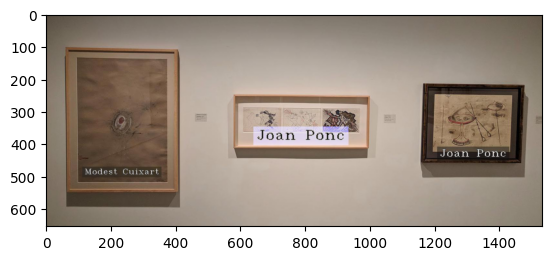

In [5]:
plt.imshow(qsd1_w4[15],)
plt.show()

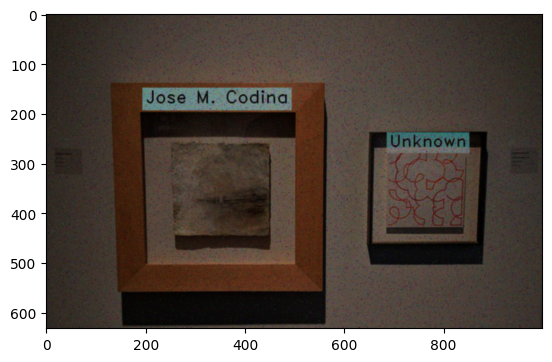

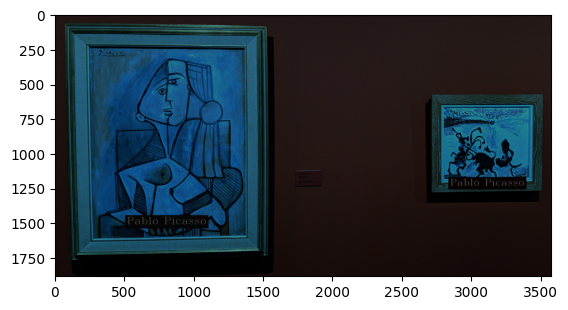

In [6]:
from skimage.exposure import adjust_gamma

qsd1_w4_filt = [adjust_gamma(img, gamma=2, gain=0.6) for img in qsd1_w4]
plt.imshow(qsd1_w4_filt[26],)
plt.show()
plt.imshow(qsd1_w4_filt[29],)
plt.show()


In [7]:
from skimage.exposure import adjust_gamma
reload(bg_masks)
res = bg_masks.generate_masks_multiple(
    qsd1_w4_filt,
    N_PROCESS=N_PROCESS,
    mssg="Generating masks with up to three components...",
    image_files=qsd1_w4_files,
    output_dir='../data/floodFill_masks_qsd1_w4/',
    n=3,
)

Generating masks with up to three components...: 100%|██████████| 30/30 [00:17<00:00,  1.76it/s]


In [8]:
# load background masks
masks_gen_floodFill_qsd1_w4, masks_gen_floodFill_qsd1_w4_files = data_handler.load_images(
    folder=f"../data/floodFill_masks_qsd1_w4/",
    extension=".png",
    desc=f"Loading background masks for QSD1-W4..."
)


Loading background masks for QSD1-W4...: 100%|██████████| 30/30 [00:00<00:00, 40.50it/s]


../data/floodFill_masks_qsd1_w4/ read: 30 images


In [9]:
reload(image_utils)

bboxes_qsd1_w4, paintings_cropped, mask_text = image_utils.crop_paintings_batch(
    qsd1_w4, qsd1_w4_files,
    masks_gen_floodFill_qsd1_w4,
    output_dir="../results/cropped_paintings_qsd1_w4/",
    extract_text_mask=True,
    flag_mask=False,
)
data_handler.save_object_pickle(bboxes_qsd1_w4, "./QSD1/text_boxes.pkl")

Done cropping paintings.
Object saved at ./QSD1/text_boxes.pkl


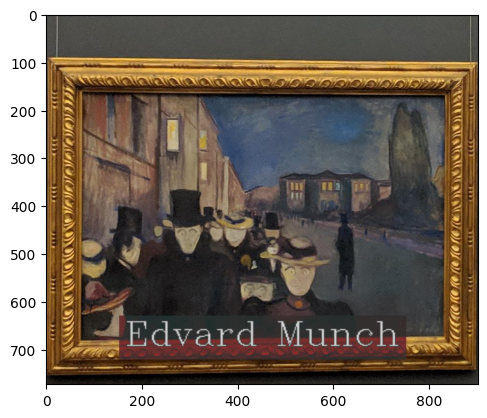

In [10]:
plt.imshow(paintings_cropped[5][0])

In [11]:
reload(text_retrieval)
pred_texts_qsd1_w4_folder = './results/text/pred_texts_greys_qsd1_w4/'
text_retrieval.generate_text_files_multiple(
    "../results/cropped_paintings_qsd1_w4/", pred_texts_qsd1_w4_folder, greys=True, binary=False)


../results/cropped_paintings_qsd1_w4/00000/0.jpg
../results/cropped_paintings_qsd1_w4/00001/0.jpg
../results/cropped_paintings_qsd1_w4/00002/0.jpg
../results/cropped_paintings_qsd1_w4/00003/0.jpg
../results/cropped_paintings_qsd1_w4/00004/0.jpg
../results/cropped_paintings_qsd1_w4/00004/1.jpg
../results/cropped_paintings_qsd1_w4/00005/0.jpg
../results/cropped_paintings_qsd1_w4/00005/1.jpg
../results/cropped_paintings_qsd1_w4/00005/2.jpg
../results/cropped_paintings_qsd1_w4/00006/0.jpg
../results/cropped_paintings_qsd1_w4/00007/0.jpg
../results/cropped_paintings_qsd1_w4/00008/0.jpg
../results/cropped_paintings_qsd1_w4/00009/0.jpg
../results/cropped_paintings_qsd1_w4/00010/0.jpg
../results/cropped_paintings_qsd1_w4/00011/0.jpg
../results/cropped_paintings_qsd1_w4/00012/0.jpg
../results/cropped_paintings_qsd1_w4/00013/0.jpg
../results/cropped_paintings_qsd1_w4/00014/0.jpg
../results/cropped_paintings_qsd1_w4/00015/0.jpg
../results/cropped_paintings_qsd1_w4/00015/1.jpg
../results/cropped_p

### ORB

In [12]:
reload(image_features)
db_keypoints_orb, db_features_orb = image_features.orb_batch(
    images=db[:], mssg="Computing ORB from BBDD...")

Computing ORB from BBDD...: 100%|██████████| 287/287 [00:37<00:00,  7.67it/s]


In [13]:
reload(image_features)
keypoints_multiple_orb, features_multiple_orb = image_features.orb_multiple(
    files_dir="../results/cropped_paintings_qsd1_w4/", mssg="Computing ORB from QSD...")

Computing ORB from QSD...: 100%|██████████| 30/30 [00:07<00:00,  3.97it/s]


## TODO: try out different similarities...

In [14]:
reload(similarities)
n_matches_qsd1_w4_orb = similarities.compute_matches_multiple(
    features_multiple=features_multiple_orb,
    db_features=db_features_orb,
    method="BF",
    similarity_measure="Hamming2",  # this is ignored if method == "FLANN,
    N_PROCESS=1,
)

Computing matches for query image 1...:   0%|          | 0/1 [00:00<?, ?it/s]

Computing matches with BF_matcher...:   0%|          | 0/287 [00:00<?, ?it/s]

Computing matches with BF_matcher...:  33%|███▎      | 96/287 [00:00<00:00, 959.18it/s]

Computing matches with BF_matcher...:  67%|██████▋   | 192/287 [00:00<00:00, 929.73it/s]

                                                                                        
Computing matches for query image 2...:   0%|          | 0/1 [00:00<?, ?it/s]

Computing matches with BF_matcher...:   0%|          | 0/287 [00:00<?, ?it/s]

Computing matches with BF_matcher...:  33%|███▎      | 96/287 [00:00<00:00, 953.38it/s]

Computing matches with BF_matcher...:  67%|██████▋   | 192/287 [00:00<00:00, 931.67it/s]

                                                                                        
Computing matches for query image 3...:   0%|          | 0/1 [00:00<?, ?it/s]

Computing matches with BF_matcher...:   0%|          | 0/287 [00:00<?

In [15]:
reload(evaluate)
top_1_multiple = evaluate.get_top_k_multiple(
    n_matches_qsd1_w4_orb, db_files, k=1, match_threshold=20)

top_5_multiple = evaluate.get_top_k_multiple(
    n_matches_qsd1_w4_orb, db_files, k=5, match_threshold=20)

In [16]:
import data_utils

reload(data_utils)
predicted_results_1_qsd1_w4_multiple = data_handler.store_outputs_multiple(
    outputs=top_1_multiple,
    save=True,
    name_file="top1",
    path="./results/qsd1_w4_multiple"
)

expected_results_qsd1_w4 = pickle.load(
    open('../data/qsd1_w4_denoised/gt_corresps.pkl', "rb"))

mapk1_qsd1_w4_multiple = evaluate.mapk_multiple(
    expected_results_qsd1_w4, predicted_results_1_qsd1_w4_multiple, k=1)

print("MAP@1 Score: {:.4f}% ({}/{})".format(mapk1_qsd1_w4_multiple*100,
      int(len(predicted_results_1_qsd1_w4_multiple)*mapk1_qsd1_w4_multiple), len(predicted_results_1_qsd1_w4_multiple)))


Results saved at ./results/qsd1_w4_multiple/result_top1.pkl
MAP@1 Score: 82.8571% (24/30)


In [ ]:
predicted_results_5_qsd1_w4_multiple = data_handler.store_outputs_multiple(
    outputs=top_5_multiple,
    save=True, 
    name_file="top5",
    path="./results/qsd1_w4_multiple")

expected_results_qsd1_w4 = pickle.load(
    open('../data/qsd1_w4_denoised/gt_corresps.pkl', "rb"))

mapk5_qsd1_w4_multiple = evaluate.mapk_multiple(
    expected_results_qsd1_w4, predicted_results_5_qsd1_w4_multiple, k=5)

print("MAP@5 Score: {:.4f}% ({}/{})".format(mapk5_qsd1_w4_multiple*100,
      int(len(predicted_results_5_qsd1_w4_multiple)*mapk5_qsd1_w4_multiple), len(predicted_results_5_qsd1_w4_multiple)))


In [ ]:
from tqdm.notebook import tqdm

reload(visualizer)
visualizer.plot_matches_(predicted_results_1_qsd1_w4_multiple, paintings_cropped, db, keypoints_multiple_orb, features_multiple_orb, db_keypoints_orb, db_features_orb)

### TODO: for matching descriptors, modify get_top_k and allow for threshold num of matches

In [ ]:
reload(evaluate)
evaluate.run_experiment_save_keypoints_descriptors(db[:], query_images_folder="../results/cropped_paintings_qsd1_w4/", save_path_="./results/keypoints/")

# RUN EXPERIMENTS

In [ ]:
"""
reload(evaluate)
reload(similarities)
evaluate.run_all_experiment_keypoints(
    threshold_list=(0,1,2,5),
    k_list=(1, 5),
    query_images_folder="../data/qsd1_w4_denoised/",
    db_images=db[:], 
    keypoints_folder="./results/keypoints/", 
    output_csv="./results/keypoints/results.csv", 
    N_PROCESS=1)
"""

# Task 4

In [ ]:
# Texture
db_texture_matrix = image_features.hog_batch(images = db[:], mssg="Histograms of Gradients (HoG) from BBDD...")
feats_multiple_qsd1_w4_texture = image_features.hog_multiple(files_dir="../results/cropped_paintings_qsd1_w4/", features_filename="qsd1_w4_hog")

similarities_multiple_qsd1_w4_texture = similarities.compute_similarities_multiple(
    features_multiple=feats_multiple_qsd1_w4_texture,
    db_features=db_texture_matrix,
    similarity_measure="hellinger_kernel",
    n_bins=None,
)

In [ ]:
# Top 1:
top_1_multiple = evaluate.get_top_k_multiple(similarities_multiple_qsd1_w4_texture, db_files, k=1, match_threshold=None)
predicted_results_1_qsd1_w4_multiple = data_handler.store_outputs_multiple(
    outputs=top_1_multiple,
    save=True, 
    name_file="top1",
    path="./results/qsd1_w4_previousweek/texture")

mapk1_qsd1_w4_multiple = evaluate.mapk_multiple(expected_results_qsd1_w4, predicted_results_1_qsd1_w4_multiple, k=1)

print("MAP@1 Score: {:.4f}% ({}/{})".format(mapk1_qsd1_w4_multiple*100,
      int(len(predicted_results_1_qsd1_w4_multiple)*mapk1_qsd1_w4_multiple), len(predicted_results_1_qsd1_w4_multiple)))


# Top 5:
top_5_multiple = evaluate.get_top_k_multiple(similarities_multiple_qsd1_w4_texture, db_files, k=5, match_threshold=None)
predicted_results_5_qsd1_w4_multiple = data_handler.store_outputs_multiple(
    outputs=top_5_multiple,
    save=True, 
    name_file="top5",
    path="./results/qsd1_w4_previousweek/texture")

mapk5_qsd1_w4_multiple = evaluate.mapk_multiple(expected_results_qsd1_w4, predicted_results_5_qsd1_w4_multiple, k=5)

print("MAP@5 Score: {:.4f}% ({}/{})".format(mapk5_qsd1_w4_multiple*100,
      int(len(predicted_results_5_qsd1_w4_multiple)*mapk5_qsd1_w4_multiple), len(predicted_results_5_qsd1_w4_multiple)))

In [ ]:
# Text
reload(text_retrieval)
similarity_multiple_qsd1_w4_text = text_retrieval.get_distances_text_2paintings(
    files_dir="../results/cropped_paintings_qsd1_w4/",
    text_database=db_text,
    dist = 'damerau_levenshtein'
)

In [ ]:
# Top 1:
top_1_multiple = evaluate.get_top_k_multiple(similarity_multiple_qsd1_w4_text, db_files, k=1, match_threshold=None)
predicted_results_1_qsd1_w4_multiple = data_handler.store_outputs_multiple(
    outputs=top_1_multiple,
    save=True, 
    name_file="top1",
    path="./results/qsd1_w4_previousweek/text")

mapk1_qsd1_w4_multiple = evaluate.mapk_multiple(expected_results_qsd1_w4, predicted_results_1_qsd1_w4_multiple, k=1)

print("MAP@1 Score: {:.4f}% ({}/{})".format(mapk1_qsd1_w4_multiple*100,
      int(len(predicted_results_1_qsd1_w4_multiple)*mapk1_qsd1_w4_multiple), len(predicted_results_1_qsd1_w4_multiple)))


# Top 5:
top_5_multiple = evaluate.get_top_k_multiple(similarity_multiple_qsd1_w4_text, db_files, k=5, match_threshold=None)
predicted_results_5_qsd1_w4_multiple = data_handler.store_outputs_multiple(
    outputs=top_5_multiple,
    save=True, 
    name_file="top5",
    path="./results/qsd1_w4_previousweek/text")

mapk5_qsd1_w4_multiple = evaluate.mapk_multiple(expected_results_qsd1_w4, predicted_results_5_qsd1_w4_multiple, k=5)

print("MAP@5 Score: {:.4f}% ({}/{})".format(mapk5_qsd1_w4_multiple*100,
      int(len(predicted_results_5_qsd1_w4_multiple)*mapk5_qsd1_w4_multiple), len(predicted_results_5_qsd1_w4_multiple)))

In [ ]:
# Color
feats_multiple_qsd1_w4_color = histogram_processing.compute_features_multiple(
    "../results/cropped_paintings_qsd1_w4",
    n_levels=5, n_bins=5,
    grayscale = False, RGB = True, CieLab = False, HSV = False, YCbCr = False,
    histogram3d = True,
    use_mask = False,
)

db_feature_matrix_color = histogram_processing.generate_feature_matrix(
    dataset=db[:],
    n_levels=5, n_bins=5,
    grayscale=False,
    RGB=True,
    CieLab=False,
    HSV=False,
    YCbCr=False,
    histogram3d=True,
    mssg="Generating features for BBDD dataset...(with N_PROCESS = {})".format(
        N_PROCESS),
    masks=None,
    N_PROCESS=N_PROCESS,
)

In [ ]:
similarity_multiple_qsd1_w4_color = similarities.compute_similarities_multiple(
    features_multiple=feats_multiple_qsd1_w4_color,
    db_features=db_feature_matrix_color,
    similarity_measure="hellinger_kernel",
    n_bins=5
)

In [ ]:
# Top 1:
top_1_multiple = evaluate.get_top_k_multiple(similarity_multiple_qsd1_w4_color, db_files, k=1, match_threshold=None)
predicted_results_1_qsd1_w4_multiple = data_handler.store_outputs_multiple(
    outputs=top_1_multiple,
    save=True, 
    name_file="top1",
    path="./results/qsd1_w4_previousweek/color")

mapk1_qsd1_w4_multiple = evaluate.mapk_multiple(expected_results_qsd1_w4, predicted_results_1_qsd1_w4_multiple, k=1)

print("MAP@1 Score: {:.4f}% ({}/{})".format(mapk1_qsd1_w4_multiple*100,
      int(len(predicted_results_1_qsd1_w4_multiple)*mapk1_qsd1_w4_multiple), len(predicted_results_1_qsd1_w4_multiple)))


# Top 5:
top_5_multiple = evaluate.get_top_k_multiple(similarity_multiple_qsd1_w4_color, db_files, k=5, match_threshold=None)
predicted_results_5_qsd1_w4_multiple = data_handler.store_outputs_multiple(
    outputs=top_5_multiple,
    save=True, 
    name_file="top5",
    path="./results/qsd1_w4_previousweek/color")

mapk5_qsd1_w4_multiple = evaluate.mapk_multiple(expected_results_qsd1_w4, predicted_results_5_qsd1_w4_multiple, k=5)

print("MAP@5 Score: {:.4f}% ({}/{})".format(mapk5_qsd1_w4_multiple*100,
      int(len(predicted_results_5_qsd1_w4_multiple)*mapk5_qsd1_w4_multiple), len(predicted_results_5_qsd1_w4_multiple)))

# Combine descriptors

In [ ]:
import copy

def get_max_multiple(list_of_lists_of_arrays):
    max_val = -99999
    for i in range(len(list_of_lists_of_arrays)):
        for j in range(len(list_of_lists_of_arrays[i])):
            max_val = np.amax([max_val, list_of_lists_of_arrays[i][j].max()])
    return max_val

def get_min_multiple(list_of_lists_of_arrays):
    min_val = 99999
    for i in range(len(list_of_lists_of_arrays)):
        for j in range(len(list_of_lists_of_arrays[i])):
            min_val = np.amin([min_val, list_of_lists_of_arrays[i][j].min()])
    return min_val

def normalize_list_of_list_of_arrays(list_of_lists_of_arrays, min, max):
    list_of_lists_of_arrays1 = copy.deepcopy(list_of_lists_of_arrays)
    for i in range(len(list_of_lists_of_arrays)):
        for j in range(len(list_of_lists_of_arrays[i])):
            list_of_lists_of_arrays1[i][j] = ( list_of_lists_of_arrays[i][j] - min ) / (max - min)
    return list_of_lists_of_arrays1

def multiply_list_of_list_of_arrays(list_of_lists_of_arrays, other):
    "Multiplication is done in-place"
    
    list_of_lists_of_arrays1 = copy.deepcopy(list_of_lists_of_arrays)
    
    for i in range(len(list_of_lists_of_arrays)):
        for j in range(len(list_of_lists_of_arrays[i])):
            list_of_lists_of_arrays1[i][j] = list_of_lists_of_arrays[i][j] * other
    return list_of_lists_of_arrays1

def sum_list_of_list_of_arrays(list_of_lists_of_arrays1, list_of_lists_of_arrays2):
    "Summation of list of lists of arrays"
    assert len(list_of_lists_of_arrays1) == len(list_of_lists_of_arrays2)
    res = []
    for i in range(len(list_of_lists_of_arrays1)):
        res_i = []
        for j in range(len(list_of_lists_of_arrays1[i])):
            res_i.append(list_of_lists_of_arrays1[i][j] + list_of_lists_of_arrays1[i][j])
        res.append(res_i)
    return res

In [ ]:
#print(similarity_multiple_qsd1_w4_color)
#print(similarity_multiple_qsd1_w4_text)

In [ ]:
# Normalize distances:
texture_max = get_max_multiple(similarities_multiple_qsd1_w4_texture)
texture_min = get_min_multiple(similarities_multiple_qsd1_w4_texture)
norm_similarity_qsd1_w4_texture = normalize_list_of_list_of_arrays(similarities_multiple_qsd1_w4_texture, texture_min, texture_max)

color_max = get_max_multiple(similarity_multiple_qsd1_w4_color)
color_min = get_min_multiple(similarity_multiple_qsd1_w4_color)
norm_similarity_qsd1_w4_color = normalize_list_of_list_of_arrays(similarity_multiple_qsd1_w4_color, color_min, color_max)

text_max = get_max_multiple(similarity_multiple_qsd1_w4_text)
text_min = get_min_multiple(similarity_multiple_qsd1_w4_text)
norm_similarity_qsd1_w4_text = normalize_list_of_list_of_arrays(similarity_multiple_qsd1_w4_text, text_min, text_max)

In [ ]:
# Combining three descriptors:
color_weight = 1
texture_weight = 1
text_weight = 1

color_component = multiply_list_of_list_of_arrays(
    norm_similarity_qsd1_w4_color,
    color_weight,
)
texture_component = multiply_list_of_list_of_arrays(
    norm_similarity_qsd1_w4_texture,
    texture_weight,
)
text_component = multiply_list_of_list_of_arrays(
    norm_similarity_qsd1_w4_text,
    text_weight,
)

sim_mat_qsd1_w4_3descrip_x = sum_list_of_list_of_arrays(
    color_component, texture_component
)

sim_mat_qsd1_w4_3descrip = sum_list_of_list_of_arrays(
    sim_mat_qsd1_w4_3descrip_x, text_component
)

In [ ]:

# Top 1:
top_1_multiple = evaluate.get_top_k_multiple(sim_mat_qsd1_w4_3descrip, db_files, k=1, match_threshold=None)
predicted_results_1_qsd1_w4_multiple = data_handler.store_outputs_multiple(
    outputs=top_1_multiple,
    save=True, 
    name_file="top1",
    path="./results/qsd1_w4_previousweek/3descrip")

mapk1_qsd1_w4_multiple = evaluate.mapk_multiple(expected_results_qsd1_w4, predicted_results_1_qsd1_w4_multiple, k=1)

print("MAP@1 Score: {:.4f}% ({}/{})".format(mapk1_qsd1_w4_multiple*100,
      int(len(predicted_results_1_qsd1_w4_multiple)*mapk1_qsd1_w4_multiple), len(predicted_results_1_qsd1_w4_multiple)))


# Top 5:
top_5_multiple = evaluate.get_top_k_multiple(sim_mat_qsd1_w4_3descrip, db_files, k=5, match_threshold=None)
predicted_results_5_qsd1_w4_multiple = data_handler.store_outputs_multiple(
    outputs=top_5_multiple,
    save=True, 
    name_file="top5",
    path="./results/qsd1_w4_previousweek/3descrip")

mapk5_qsd1_w4_multiple = evaluate.mapk_multiple(expected_results_qsd1_w4, predicted_results_5_qsd1_w4_multiple, k=5)

print("MAP@5 Score: {:.4f}% ({}/{})".format(mapk5_qsd1_w4_multiple*100,
      int(len(predicted_results_5_qsd1_w4_multiple)*mapk5_qsd1_w4_multiple), len(predicted_results_5_qsd1_w4_multiple)))

In [ ]:
from skimage.io import imread

def plot_image_and_similar_multiple(qs, top_k_qs) -> None:

    for i in range(min(5, len(qs))):
        query = qs[i]

        f, axarr = plt.subplots(1, 1+len(top_k_qs[i]), figsize=(10, 10))
        axarr[0].imshow(query)
        axarr[0].title.set_text("query")
        for j in range(len(top_k_qs[i])):
            res = imread(top_k_qs[i][j][0])
            axarr[1+j].imshow(res)
            axarr[1+j].title.set_text(f"res {j}")
        plt.show()
        
        
plot_image_and_similar_multiple(qsd1_w4, top_5_multiple)